In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import imageio
import glob
import cv2
import skimage
from imageio import imread
import csv
import math
import ktrain
from keras_lr_finder import LRFinder

# Creating a generator to load and preprocess the images

In [2]:
train_csv_path = "/home/houcem/data/data.csv"
val_csv_path = "/home/houcem/data_val/data.csv"
train_sample_size = sum(1 for row in open(train_csv_path))
val_sample_size = sum(1 for row in open(val_csv_path))

In [3]:
batch_size = 32

In [4]:
def generator(csv_path, batch_size):
    X_train = []
    y_train = []
    batchcount = 0
    
    while True: #Keeping the generator running
        with open(csv_path) as f:
            next(f) #Skipping the header
            for line in f:
                img_x_path, throttle, steering_angle, img_y_path = line.split(',')
                
                #Loading and Normalizing the input frame
                img_x = imread(str(img_x_path))
                img_x = img_x/255.0
                
                #Packing the motor input into a numpy array
                motor_input = np.asarray([throttle, steering_angle])
                
                #Loading and Normalizing the target frame
                #img_y = cv2.imread(img_y_path.rstrip("\n"))
                #img_y = img_y/255.0
                
                #Packing and adding the inputs and targets into the batch
                X_train.append(img_x)
                y_train.append(img_x)
                   
                batchcount += 1    
                    
                if batchcount == batch_size:
                    X_train = np.asarray(X_train)
                    y_train = np.asarray(y_train)
                    yield(X_train, y_train)
                    X_train = []
                    y_train = []
                    batchcount = 0

In [5]:
def babbling_generator(csv_path, batch_size):
    X_train = []
    y_train = []
    motor_train = []
    batchcount = 0
    
    while True: #Keeping the generator running
        with open(csv_path) as f:
            next(f) #Skipping the header
            for line in f:
                img_x_path, throttle, steering_angle, img_y_path = line.split(',')
                
                #Loading and Normalizing the input frame
                img_x = imread(str(img_x_path))
                img_x = img_x/255.0
                
                #Packing the motor input into a numpy array
                motor_input = np.asarray([float(throttle), float(steering_angle)])
                
                #Loading and Normalizing the target frame
                img_y = cv2.imread(str(img_y_path).rstrip("\n"))
                img_y = img_y/255.0
                
                #Packing and adding the inputs and targets into the batch
                X_train.append(img_x)
                motor_train.append(motor_input)
                y_train.append(img_y)
                   
                batchcount += 1    
                    
                if batchcount == batch_size:
                    X_train = np.asarray(X_train)
                    motor_train = np.asarray(motor_train)                    
                    y_train = np.asarray(y_train)
                    yield([X_train, motor_train], y_train)
                    X_train = []
                    y_train = []
                    motor_train = []
                    batchcount = 0

# Defining the model

In [6]:
from tensorflow import keras
import tensorflow as tf
from keras import layers
#tf.config.experimental_run_functions_eagerly(True)
#tf.compat.v1.disable_eager_execution()

In [7]:
from keras.layers import Lambda, Conv2D, Conv2DTranspose, Dense, Input, Flatten, Concatenate, Reshape, BatchNormalization, Dropout, MaxPooling2D, UpSampling2D, GaussianNoise
from keras.activations import relu, linear
from keras import Model
from keras.callbacks import Callback, ReduceLROnPlateau,EarlyStopping
from keras import backend as K
from keras.losses import binary_crossentropy

In [8]:
image_input = Input(shape=(112,112,3))
x = Conv2D(8, (3,3), activation = 'relu', padding = 'same')(image_input)
x = MaxPooling2D()(x)
x = Conv2D(16, (3,3), activation = 'relu', padding = 'same')(x)
x = MaxPooling2D()(x)
x = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(x)
x = MaxPooling2D()(x)
x = Conv2D(64, (3,3), activation = 'relu', padding = 'same')(x)
x = MaxPooling2D()(x)
x = Flatten()(x)

z = Dense(49, activation ='relu')(x)

encoder = Model(inputs= [image_input], outputs = [z])

encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 112, 112, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 112, 112, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0     

In [9]:
input_decoder = Input(shape=(49,))

d = Dense(3136, activation = 'relu')(input_decoder)
d = Reshape((7,7,64))(d)
d = UpSampling2D()(d)
d = Conv2D(64,(3, 3), strides=1, activation='relu', padding='same')(d)
d = UpSampling2D()(d)
d = Conv2D(32,(3, 3), strides=1, activation='relu', padding='same')(d)
d = UpSampling2D()(d)
d = Conv2D(16,(3, 3), strides=1, activation='relu', padding='same')(d)
d = UpSampling2D()(d)
d = Conv2D(8,(3, 3), strides=1, activation='relu', padding='same')(d)
decoded = Conv2D(3, (3, 3), strides = 1, activation='relu', padding='same')(d)

Decoder = Model(inputs = input_decoder, outputs = decoded)

In [10]:
Decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 49)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              156800    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        1846

# Creating the autoencoder

In [11]:
img_input = Input(shape=(112, 112, 3))
Encoded = encoder([img_input])
Noise = GaussianNoise(0.3)(Encoded)
Decoded = Decoder(Noise)

autoencoder = Model(inputs = [img_input], outputs = Decoded)

In [12]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 112, 112, 3)]     0         
_________________________________________________________________
model (Model)                (None, 49)                178241    
_________________________________________________________________
gaussian_noise (GaussianNois (None, 49)                0         
_________________________________________________________________
model_1 (Model)              (None, 112, 112, 3)       218195    
Total params: 396,436
Trainable params: 396,436
Non-trainable params: 0
_________________________________________________________________


# Autoencoder training

In [13]:
autoencoder.compile(loss = 'mse', optimizer= keras.optimizers.Adam()) #previous learning rate is 10e-4

In [14]:
autoencoder.fit(generator(train_csv_path, batch_size), steps_per_epoch = train_sample_size/batch_size, epochs = 100, validation_data=generator(val_csv_path, batch_size), validation_steps=val_sample_size/batch_size)

Epoch 1/100
1563/1562 [==============================] - 64s 41ms/step - loss: 0.0191 - val_loss: 0.0092
Epoch 2/100
1563/1562 [==============================] - 66s 42ms/step - loss: 0.0090 - val_loss: 0.0079
Epoch 3/100
1563/1562 [==============================] - 63s 41ms/step - loss: 0.0079 - val_loss: 0.0069
Epoch 4/100
1563/1562 [==============================] - 61s 39ms/step - loss: 0.0073 - val_loss: 0.0070
Epoch 5/100
1563/1562 [==============================] - 62s 40ms/step - loss: 0.0070 - val_loss: 0.0066
Epoch 6/100
1563/1562 [==============================] - 60s 39ms/step - loss: 0.0069 - val_loss: 0.0062
Epoch 7/100
1563/1562 [==============================] - 62s 40ms/step - loss: 0.0067 - val_loss: 0.0061
Epoch 8/100
1563/1562 [==============================] - 62s 40ms/step - loss: 0.0067 - val_loss: 0.0061
Epoch 9/100
1563/1562 [==============================] - 59s 37ms/step - loss: 0.0064 - val_loss: 0.0061
Epoch 10/100
1563/1562 [==============================]

1563/1562 [==============================] - 62s 40ms/step - loss: 0.0055 - val_loss: 0.0052
Epoch 79/100
1563/1562 [==============================] - 60s 39ms/step - loss: 0.0056 - val_loss: 0.0052
Epoch 80/100
1563/1562 [==============================] - 59s 38ms/step - loss: 0.0055 - val_loss: 0.0052
Epoch 81/100
1563/1562 [==============================] - 58s 37ms/step - loss: 0.0055 - val_loss: 0.0053
Epoch 82/100
1563/1562 [==============================] - 58s 37ms/step - loss: 0.0055 - val_loss: 0.0053
Epoch 83/100
1563/1562 [==============================] - 59s 38ms/step - loss: 0.0055 - val_loss: 0.0052
Epoch 84/100
1563/1562 [==============================] - 58s 37ms/step - loss: 0.0055 - val_loss: 0.0052
Epoch 85/100
1563/1562 [==============================] - 58s 37ms/step - loss: 0.0055 - val_loss: 0.0052
Epoch 86/100
1563/1562 [==============================] - 59s 38ms/step - loss: 0.0055 - val_loss: 0.0052
Epoch 87/100
1563/1562 [==============================] - 5

In [14]:
autoencoder.save_weights("autoencoder_upsampling_noisy.h5")

# Let's check out the prediction for the first image

In [25]:
csv_file = open(train_csv_path)
next(csv_file)

'img_x,throttle,steer,img_y\n'

In [26]:
img_x_path, throttle, steering_angle, img_y_path = next(csv_file).split(',')

In [27]:
showed_image = imread(img_x_path)

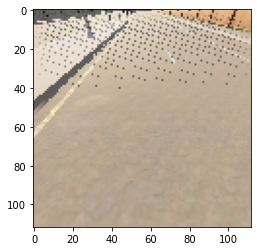

In [28]:
plt.imshow(showed_image)

In [29]:
img = imread(img_x_path)
img = img/255.0
img = img.reshape([1,112,112,3])

In [30]:
result = autoencoder.predict(img)

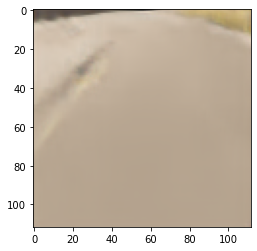

In [31]:
plt.imshow(result.reshape([112,112,3]))

# Building the motor babbling MLP

In [24]:
autoencoder.load_weights('autoencoder_upsampling_noisy.h5') 

In [15]:
autoencoder.trainable = False

In [16]:
latent_input = Input(shape=(49,))

motor_input = Input(shape=(2,))

babbling_input = Concatenate()([latent_input, motor_input])

z = Dense(512, activation = 'relu')(babbling_input)
z = Dense(49, activation = 'relu')(z)

babbling_mlp = Model(inputs = [latent_input, motor_input], outputs = z)

In [17]:
babbling_mlp.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 49)]         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 51)           0           input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 512)          26624       concatenate[0][0]          

In [18]:
img_input = Input(shape=(112, 112, 3), name = "img")
motor_input = Input(shape=(2,), name = "motor")

Encoded = encoder([img_input])
babbling = babbling_mlp([Encoded, motor_input])
Decoded = Decoder(babbling)

babbling_model = Model(inputs = [img_input, motor_input], outputs = Decoded)

In [19]:
babbling_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 49)           178241      img[0][0]                        
__________________________________________________________________________________________________
motor (InputLayer)              [(None, 2)]          0                                            
__________________________________________________________________________________________________
model_3 (Model)                 (None, 49)           51761       model[2][0]                      
                                                                 motor[0][0]                

In [20]:
babbling_model.compile(loss = 'mse', optimizer = keras.optimizers.Adam(learning_rate=0.00007))

In [21]:
batch_size = 32

In [22]:
babbling_model.fit(babbling_generator(train_csv_path, batch_size), steps_per_epoch = train_sample_size/batch_size, epochs = 10, validation_data=babbling_generator(val_csv_path, batch_size), validation_steps= val_sample_size/batch_size)

Epoch 1/10
1563/1562 [==============================] - 106s 68ms/step - loss: 0.3570 - val_loss: 0.2616
Epoch 2/10
1563/1562 [==============================] - 92s 59ms/step - loss: 0.2494 - val_loss: 0.2452
Epoch 3/10
1563/1562 [==============================] - 83s 53ms/step - loss: 0.2403 - val_loss: 0.2401
Epoch 4/10
1563/1562 [==============================] - 80s 51ms/step - loss: 0.2378 - val_loss: 0.2390
Epoch 5/10
1563/1562 [==============================] - 80s 51ms/step - loss: 0.2375 - val_loss: 0.2389
Epoch 6/10
1563/1562 [==============================] - 80s 51ms/step - loss: 0.2375 - val_loss: 0.2389
Epoch 7/10
1563/1562 [==============================] - 80s 51ms/step - loss: 0.2374 - val_loss: 0.2386
Epoch 8/10
1563/1562 [==============================] - 80s 51ms/step - loss: 0.2372 - val_loss: 0.2385
Epoch 9/10
1563/1562 [==============================] - 81s 52ms/step - loss: 0.2370 - val_loss: 0.2384
Epoch 10/10
1563/1562 [==============================] - 81s 52

# Let's see what the output looks like

In [23]:
predictions = babbling_model.predict(babbling_generator(val_csv_path, batch_size), steps=val_sample_size/batch_size)

In [40]:
csv_file = open(val_csv_path)
next(csv_file)

'img_x,throttle,steer,img_y\n'

In [62]:
img_x_path, throttle, steering_angle, img_y_path = next(csv_file).split(',')

In [63]:
motor_input = np.asarray([float(throttle), float(steering_angle)])

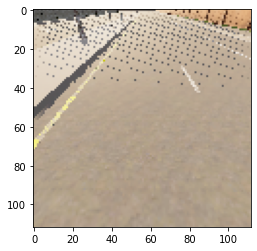

In [64]:
showed_image = imread(img_y_path.rstrip("\n"))
plt.imshow(showed_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


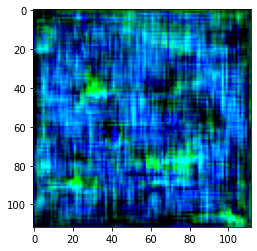

In [24]:
plt.imshow(predictions[12])